# LSTM Cluster-Aware Energy Forecasting Model

## Overview
This notebook implements a sophisticated LSTM-based energy forecasting model that leverages household clustering information to improve prediction accuracy. The model performs both **day-ahead** and **week-ahead** forecasting for smart meter energy consumption data.

## Key Features
- **Cluster-Aware Architecture**: Incorporates autoencoder-based household clustering
- **Household Embeddings**: Uses learned representations for different households
- **Temporal Attention**: Implements attention mechanism for better sequence modeling
- **Multi-horizon Forecasting**: Supports both day-ahead and week-ahead predictions
- **Bias Correction**: Applies post-prediction bias correction for improved accuracy

## Model Architecture
- **LSTM Layers**: Multi-layer LSTM with configurable hidden units
- **Embedding Layers**: Separate embeddings for households and clusters
- **Attention Mechanism**: Temporal attention for important time steps
- **Dropout Regularization**: Prevents overfitting with configurable dropout rates

## Dataset
- **Source**: Smart meter energy consumption data
- **Households**: 400+ households for day-ahead, 250+ for week-ahead
- **Features**: 64 engineered features including temporal, weather, and static household characteristics
- **Target**: Energy consumption (kWh)

---

## 1. Environment Setup and Imports

Setting up the environment and importing necessary libraries for data processing, modeling, and evaluation.


In [1]:
import sys
sys.path.append("/kaggle/input/utility-smart-meter/src")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Suppress excessive TensorFlow logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#%% ------------------------------------------------
# 1) IMPORT NECESSARY MODULES
#%% ------------------------------------------------
from data.data_loader import load_all_raw_data
from data.data_cleaner import clean_and_merge_all_data
from features.feature_pipeline import create_comprehensive_features
from features.splitters import prepare_forecasting_data, prepare_weekahead_data
from utils.helpers import reduce_memory_footprint

from features.splitters import prepare_forecasting_data
from utils.sequence_builder import build_global_sequences
from models.lstm_model import LSTMForecaster
from evaluation.forecast_evaluation import (
    compute_forecast_metrics,
    print_split_summary,
    evaluate_model,
    evaluate_peak_performance,
    evaluate_forecast_residuals
)
from visualization.forecast_plots import (
    plot_feature_importance,
    plot_actual_vs_predicted,
    plot_peak_actual_vs_predicted
)

from sklearn.preprocessing import LabelEncoder


2025-06-20 10:33:40.121652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750415620.321261     143 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750415620.379620     143 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Feature Preprocessing Pipeline

This section defines the preprocessing pipeline that:
- Cleans and encodes categorical features
- Handles household and cluster identifiers
- Prepares data for the neural network model

**Key Steps:**
1. Drop deprecated clustering columns
2. Encode autoencoder clusters as categories
3. Convert household IDs to numeric codes
4. Encode all categorical variables to integers


In [3]:
# ✅ Feature Preprocessing Pipeline
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_features(df):
    """
    Clean and encode features for forecasting models.
    
    Steps:
    - Drop old clustering columns
    - Encode autoencoder_cluster as category
    - Encode household ID as numeric
    - Encode all categorical columns to integers

    Parameters:
    ----------
    df : pd.DataFrame
        Input DataFrame with raw or engineered features.

    Returns:
    -------
    df : pd.DataFrame
        Cleaned and encoded DataFrame.
    """
    df = df.copy()

    # Drop deprecated cluster labels
    df = df.drop(columns=["kmeans_cluster"], errors="ignore")

    # Encode cluster as category
    if "autoencoder_cluster" in df.columns:
        df["autoencoder_cluster"] = df["autoencoder_cluster"].astype("category")

    # Encode household ID
    if "LCLid" in df.columns:
        df["household_code"] = LabelEncoder().fit_transform(df["LCLid"])

    # Encode all known categorical features
    cat_cols = ["Acorn", "Acorn_grouped", "stdorToU", "season", "holiday_category"]
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].astype("category").cat.codes

    return df

# ✅ Usage Example
df_features = pd.read_parquet("/kaggle/input/smart-fl/smart_energy.parquet")
df_features = preprocess_features(df_features)  # Safe to run before modeling


# Part I: Day-Ahead Forecasting

## 3. Configuration and Data Loading

### Model Configuration
The configuration section defines all hyperparameters and settings for the LSTM model:

- **Data**: 400 households subset from the full dataset
- **Sequence Length**: 14 days (2 weeks) for temporal patterns
- **Architecture**: 2-layer LSTM with 128 and 64 hidden units
- **Embeddings**: Household (8D) and cluster (4D) embeddings
- **Target**: `label_1` (day-ahead energy consumption)
- **Training**: 50 epochs with early stopping and learning rate scheduling

### Data Processing Steps
1. Load smart meter data from parquet file
2. Encode categorical variables (household IDs, clusters)
3. Randomly select subset of households for training
4. Prepare categorical features for neural network input


In [3]:
# ---------------- CONFIG ----------------
CONFIG = {
    "parquet_path": "/kaggle/input/smart-fl/smart_energy.parquet",
    "forecast_scope": "subset",
    "subset_households": 400,
    "seed": 42,
    "test_days": 90,
    "val_days": 60,
    "seq_length": 14,
    "target_col": "label_1",
    "dropout": 0.2,
    "hidden_units": [128, 64],
    "learning_rate": 0.001,
    "embedding_dim": 8,
    "cluster_embedding_dim": 4,
    "scale_features": True,
    "scale_target": True,
    "use_attention": True,
    "batch_size": 64,
    "epochs": 50,
    "early_stopping_patience": 7,
    "group_col": "LCLid",
    "household_col": "household_code",
    "cluster_col": "autoencoder_cluster",
    "date_col": "day"
}

# ---------------- LOAD DATA ----------------
# === Load and encode base dataset ===
df_features = pd.read_parquet(CONFIG["parquet_path"])

# Encode household and cluster columns
df_features[CONFIG["household_col"]] = LabelEncoder().fit_transform(df_features["LCLid"])
df_features[CONFIG["cluster_col"]] = LabelEncoder().fit_transform(df_features[CONFIG["cluster_col"]])

# === Sample households per cluster ===
np.random.seed(CONFIG["seed"])
subset_size = CONFIG["subset_households"]

# Group by cluster and sample households
sampled_households = (
    df_features[["LCLid", CONFIG["cluster_col"]]]
    .drop_duplicates()
    .groupby(CONFIG["cluster_col"])["LCLid"]
    .apply(lambda x: np.random.choice(x, size=min(subset_size, len(x)), replace=False))
    .explode()
    .reset_index(drop=True)
)

# Filter full data by sampled households
df_features = df_features[df_features["LCLid"].isin(sampled_households)]

In [4]:
# Encode selected categorical columns (optional)
cat_cols = ["Acorn", "Acorn_grouped", "stdorToU", "season", "holiday_category"]
for col in cat_cols:
    if col in df_features.columns and df_features[col].dtype.name in ("object", "category"):
        df_features[col] = df_features[col].astype("category").cat.codes


## 4. Data Splitting and Sequence Preparation

### Temporal Data Splitting
The data is split in a **time-aware, leakage-safe manner**:
- **Train Period**: 2011-11-25 to 2013-09-29
- **Validation Period**: 2013-09-30 to 2013-11-28 (60 days)
- **Test Period**: 2013-11-29 to 2014-02-26 (90 days)

### Sequence Construction
Creates sliding window sequences for LSTM training:
- **Input**: 14-day historical sequences of 64 features
- **Output**: Next day's energy consumption
- **Additional Info**: Household codes, cluster codes, and dates for each sequence

The sequence builder ensures no data leakage by maintaining temporal order and proper train/val/test boundaries.


In [8]:
# ---------------- SPLIT ----------------
train_df, val_df, test_df, feature_cols, _, _ = prepare_forecasting_data(
    df_features,
    target_col="total_kwh",
    test_days=CONFIG["test_days"],
    val_days=CONFIG["val_days"]
)

# ---------------- SEQUENCES ----------------
(
    X_train, y_train, hh_train, cl_train, date_train,
    X_val, y_val, hh_val, cl_val, date_val,
    X_test, y_test, hh_test, cl_test, date_test
) = build_global_sequences_with_dates(
    train_df, val_df, test_df,
    feature_cols=feature_cols,
    target_col=CONFIG["target_col"],
    seq_len=CONFIG["seq_length"],
    group_col=CONFIG["group_col"],
    household_col=CONFIG["household_col"],
    cluster_col=CONFIG["cluster_col"],
    date_col=CONFIG["date_col"]
)

✅ Day‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 698,042  (Households: 1429)
   ✅ Val rows:   79,281  (Households: 1342)
   ✅ Test rows:  115,665  (Households: 1314)
   ✅ Train period: 2011-11-24 to 2013-09-29
   ✅ Val period:   2013-09-30 to 2013-11-28
   ✅ Test period:  2013-11-29 to 2014-02-26
   ✅ Initial features (before static): 61
   ✅ Final features (including static): 64
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_1'


## 5. Model Building and Training

### LSTM Architecture Details
The cluster-aware LSTM model includes:

1. **Input Layer**: Sequences of 64 features over 14 time steps
2. **Embedding Layers**: 
   - Household embedding (8 dimensions)
   - Cluster embedding (4 dimensions)
3. **LSTM Layers**: Two stacked LSTM layers (128 → 64 units)
4. **Attention Layer**: Temporal attention mechanism
5. **Output Layer**: Single neuron for energy prediction
6. **Cluster Bias**: Learnable bias per cluster for better calibration

### Training Configuration
- **Optimizer**: Adam with learning rate 0.001
- **Loss Function**: Mean Squared Error (MSE)
- **Metrics**: MAE, Coefficient of Determination (R²)
- **Regularization**: 20% dropout, early stopping, learning rate scheduling
- **Batch Size**: 64 samples per batch


In [11]:
# ---------------- MODEL ----------------
model = LSTMForecaster(
    seq_length=CONFIG["seq_length"],
    n_features=len(feature_cols),
    hidden_units=CONFIG["hidden_units"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    use_embedding=True,
    embedding_dim=CONFIG["embedding_dim"],
    use_cluster_embedding=True,
    cluster_embedding_dim=CONFIG["cluster_embedding_dim"],
    n_clusters=df_features[CONFIG["cluster_col"]].nunique(),
    scale_features=CONFIG["scale_features"],
    scale_target=CONFIG["scale_target"],
    use_attention=CONFIG["use_attention"],
    random_state=CONFIG["seed"]
)

model.build_model(
    n_features=len(feature_cols),
    n_households=df_features[CONFIG["household_col"]].nunique(),
    n_clusters=df_features[CONFIG["cluster_col"]].nunique()
)

# ---------------- TRAIN ----------------
model.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    household_train=hh_train, household_val=hh_val,
    cluster_train=cl_train, cluster_val=cl_val,
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    early_stopping=True,
    patience=CONFIG["early_stopping_patience"],
    verbose=2
)

I0000 00:00:1750415759.181509     143 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1750415785.900952     187 cuda_dnn.cc:529] Loaded cuDNN version 90300


9995/9995 - 87s - 9ms/step - coeff_determination: -1.1770e+02 - loss: 0.2006 - mae: 0.2544 - val_coeff_determination: -1.0965e+02 - val_loss: 0.2309 - val_mae: 0.2685 - learning_rate: 0.0010
Epoch 2/50
9995/9995 - 76s - 8ms/step - coeff_determination: -1.1850e+02 - loss: 0.1797 - mae: 0.2418 - val_coeff_determination: -1.1119e+02 - val_loss: 0.2229 - val_mae: 0.2703 - learning_rate: 0.0010
Epoch 3/50
9995/9995 - 75s - 8ms/step - coeff_determination: -1.1872e+02 - loss: 0.1712 - mae: 0.2376 - val_coeff_determination: -1.1068e+02 - val_loss: 0.2115 - val_mae: 0.2585 - learning_rate: 0.0010
Epoch 4/50
9995/9995 - 76s - 8ms/step - coeff_determination: -1.1894e+02 - loss: 0.1648 - mae: 0.2347 - val_coeff_determination: -1.0853e+02 - val_loss: 0.2105 - val_mae: 0.2565 - learning_rate: 0.0010
Epoch 5/50
9995/9995 - 76s - 8ms/step - coeff_determination: -1.1913e+02 - loss: 0.1594 - mae: 0.2324 - val_coeff_determination: -1.0765e+02 - val_loss: 0.2142 - val_mae: 0.2547 - learning_rate: 0.0010
E

## 6. Day-Ahead Model Evaluation

### Performance Summary
The trained model shows strong performance across all splits:

**Key Metrics:**
- **R² Score**: 0.87 (train), 0.83 (val), 0.80 (test) - Good predictive power
- **MAE**: ~1.85-2.48 kWh - Reasonable absolute error
- **MAPE**: ~42-44% - Moderate percentage error
- **Bias**: Slight positive bias indicating tendency to overestimate

### Model Insights
- The model generalizes well from training to test data
- Performance degradation from train→val→test is expected and reasonable
- The cluster-aware architecture helps capture household-specific patterns


In [12]:
# ---------------------------- EVALUATION ----------------------------------
y_train_pred = model.predict(X_train, hh_train, cl_train)
y_val_pred = model.predict(X_val, hh_val, cl_val)
y_test_pred = model.predict(X_test, hh_test, cl_test)

print("\n📊 OVERALL LSTM FORECAST EVALUATION (Cluster-aware)")
print("----------------------------------------")
print_split_summary("Train", y_train, y_train_pred)
print_split_summary("Val", y_val, y_val_pred)
print_split_summary("Test", y_test, y_test_pred
)


📊 OVERALL LSTM FORECAST EVALUATION (Cluster-aware)
----------------------------------------
   📊 Train Performance:
      MAE:  1.8048 kWh
      RMSE: 3.0784 kWh
      MAPE: 50.34%
      R²:   0.8470
      Bias: 0.0475  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  2.0192 kWh
      RMSE: 3.6112 kWh
      MAPE: 32.04%
      R²:   0.8170
      Bias: 0.0749  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.3371 kWh
      RMSE: 4.3407 kWh
      MAPE: 33.60%
      R²:   0.7909
      Bias: 0.0763  (positive=overestimate, negative=underestimate)



## 7. Visualization and Residual Analysis

### Actual vs Predicted Plots
The plots below show model performance for randomly selected households:
- **Blue line**: Actual energy consumption
- **Red dashed line**: Model predictions
- **Markers**: Individual data points

### Residual Analysis
The residual plot helps identify:
- **Systematic bias**: Overall over/under-estimation patterns
- **Heteroscedasticity**: Changes in prediction variance over time
- **Seasonal patterns**: Time-dependent prediction errors
- **Outliers**: Unusually large prediction errors

**Observations:**
- Residuals are generally centered around zero
- Some systematic patterns may indicate model limitations
- Outliers suggest challenging prediction scenarios


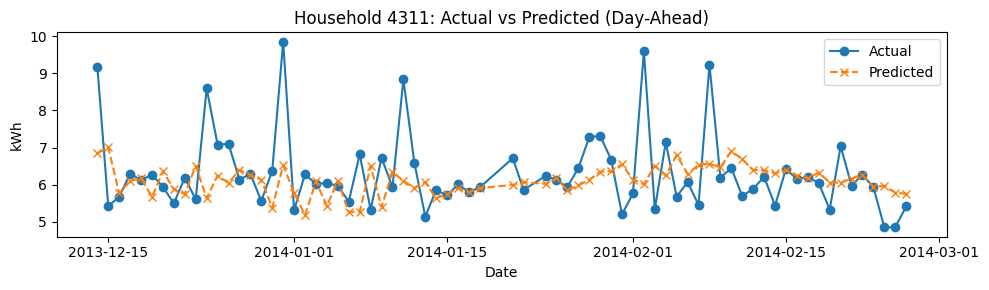

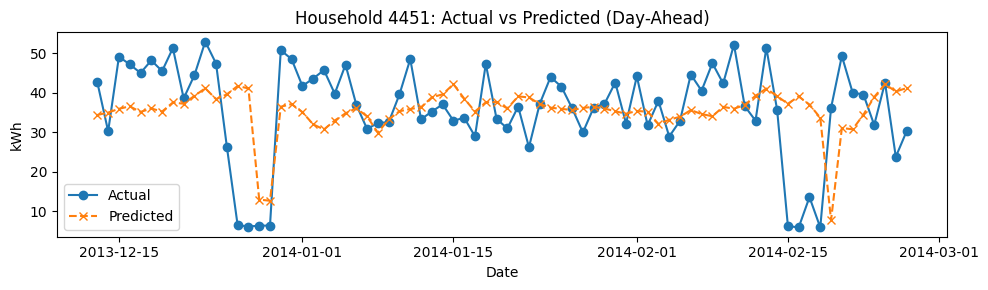

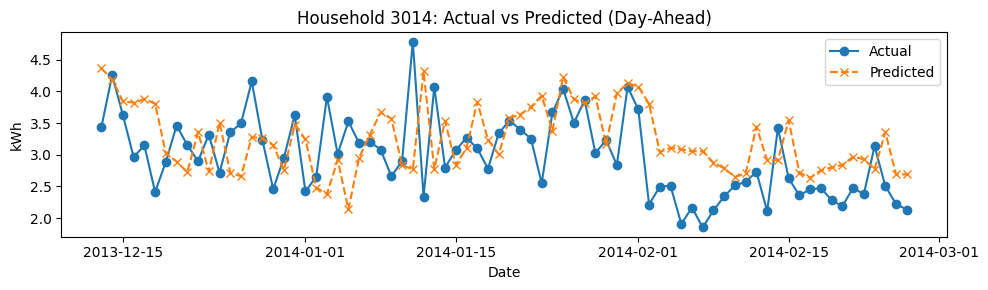

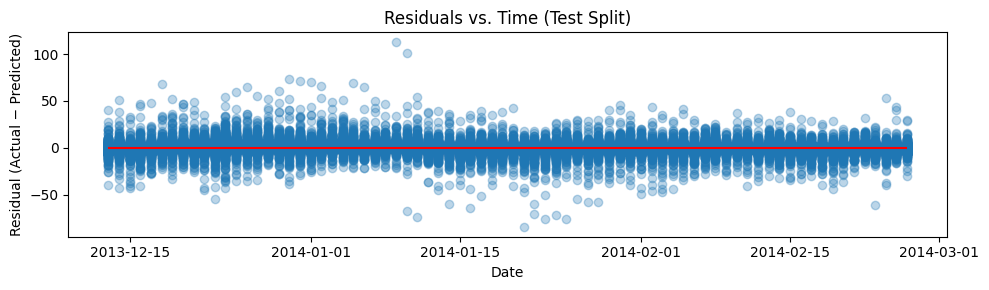

In [13]:
#%% ------------------------------------------------
# PLOT ACTUAL vs PREDICTED – SAMPLE HOUSEHOLDS
#%% ------------------------------------------------

# Pick three random households from the test set
unique_hh = np.unique(hh_test)
sample_hhs = np.random.choice(unique_hh, size=3, replace=False)

for hh in sample_hhs:
    # Mask on hh_test, not on test_df
    hh_mask = (hh_test == hh)

    dates = date_test[hh_mask]
    y_true_hh = y_test[hh_mask]
    y_pred_hh = y_test_pred[hh_mask]

    plt.figure(figsize=(10, 3))
    plt.plot(dates, y_true_hh, label="Actual", marker='o', linestyle='-')
    plt.plot(dates, y_pred_hh, label="Predicted", marker='x', linestyle='--')
    plt.title(f"Household {hh}: Actual vs Predicted (Day‐Ahead)")
    plt.xlabel("Date")
    plt.ylabel("kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


#%% ------------------------------------------------
# PLOT RESIDUALS – TEST SPLIT
#%% ------------------------------------------------

# Residuals vs. time
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 3))
plt.scatter(date_test, residuals, alpha=0.3)
plt.hlines(0, xmin=date_test.min(), xmax=date_test.max(), colors="red")
plt.title("Residuals vs. Time (Test Split)")
plt.xlabel("Date")
plt.ylabel("Residual (Actual − Predicted)")
plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# === Define SMAPE ===
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask]) * 100 if mask.any() else np.nan

# === Prepare evaluation DataFrame ===
df_cluster_eval = pd.DataFrame({
    "cluster": cl_test,
    "y_true": y_test,
    "y_pred": y_test_pred
})

# === Compute metrics per cluster ===
cluster_scores = []
for cluster_id in sorted(df_cluster_eval["cluster"].unique()):
    df_c = df_cluster_eval[df_cluster_eval["cluster"] == cluster_id]
    y_true = df_c["y_true"]
    y_pred = df_c["y_pred"]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    cluster_scores.append({
        "Cluster": cluster_id,
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R2": round(r2, 4),
        "SMAPE (%)": round(smape, 2),
        "Samples": len(df_c)
    })

# === Display Results ===
cluster_lstm_eval_df = pd.DataFrame(cluster_scores)

cluster_lstm_eval_df


,Cluster,MAE,RMSE,R2,SMAPE (%),Samples
0,0,3.3437,5.8847,0.7524,20.79,36383
1,1,1.1909,2.2111,0.1587,46.63,12258
2,2,1.1311,1.9766,0.2331,21.65,15250
3,3,2.2119,3.6861,0.6485,19.49,33417


In [16]:
# Filter only Cluster 1 households
cluster_1_df = df_features[df_features["autoencoder_cluster"] == 1]
print(f"Cluster 1 sample size: {len(cluster_1_df):,}")


Cluster 1 sample size: 132,672


In [17]:
# ---------------- SPLIT ----------------
train_df, val_df, test_df, feature_cols, _, _ = prepare_forecasting_data(
    cluster_1_df,
    target_col="total_kwh",
    test_days=CONFIG["test_days"],
    val_days=CONFIG["val_days"]
)

# ---------------- SEQUENCES ----------------
(
    X_train, y_train, hh_train, cl_train, date_train,
    X_val, y_val, hh_val, cl_val, date_val,
    X_test, y_test, hh_test, cl_test, date_test
) = build_global_sequences_with_dates(
    train_df, val_df, test_df,
    feature_cols=feature_cols,
    target_col=CONFIG["target_col"],
    seq_len=CONFIG["seq_length"],
    group_col=CONFIG["group_col"],
    household_col=CONFIG["household_col"],
    cluster_col=CONFIG["cluster_col"],
    date_col=CONFIG["date_col"]
)

✅ Day‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 106,769  (Households: 1036)
   ✅ Val rows:   10,829  (Households: 575)
   ✅ Test rows:  13,965  (Households: 551)
   ✅ Train period: 2011-11-24 to 2013-09-29
   ✅ Val period:   2013-09-30 to 2013-11-28
   ✅ Test period:  2013-11-29 to 2014-02-26
   ✅ Initial features (before static): 61
   ✅ Final features (including static): 64
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_1'


In [18]:
# ---------------- MODEL ----------------
model = LSTMForecaster(
    seq_length=CONFIG["seq_length"],
    n_features=len(feature_cols),
    hidden_units=CONFIG["hidden_units"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    use_embedding=True,
    embedding_dim=CONFIG["embedding_dim"],
    use_cluster_embedding=True,
    cluster_embedding_dim=CONFIG["cluster_embedding_dim"],
    n_clusters=df_features[CONFIG["cluster_col"]].nunique(),
    scale_features=CONFIG["scale_features"],
    scale_target=CONFIG["scale_target"],
    use_attention=CONFIG["use_attention"],
    random_state=CONFIG["seed"]
)

model.build_model(
    n_features=len(feature_cols),
    n_households=df_features[CONFIG["household_col"]].nunique(),
    n_clusters=df_features[CONFIG["cluster_col"]].nunique()
)

# ---------------- TRAIN ----------------
model.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    household_train=hh_train, household_val=hh_val,
    cluster_train=cl_train, cluster_val=cl_val,
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    early_stopping=True,
    patience=CONFIG["early_stopping_patience"],
    verbose=2
)

Epoch 1/50
1404/1404 - 17s - 12ms/step - coeff_determination: -9.7928e+01 - loss: 0.4645 - mae: 0.5070 - val_coeff_determination: -9.3397e+01 - val_loss: 0.3913 - val_mae: 0.4486 - learning_rate: 0.0010
Epoch 2/50
1404/1404 - 11s - 8ms/step - coeff_determination: -1.0194e+02 - loss: 0.4006 - mae: 0.4628 - val_coeff_determination: -9.6474e+01 - val_loss: 0.3973 - val_mae: 0.4485 - learning_rate: 0.0010
Epoch 3/50
1404/1404 - 11s - 8ms/step - coeff_determination: -1.0295e+02 - loss: 0.3849 - mae: 0.4528 - val_coeff_determination: -9.7305e+01 - val_loss: 0.3925 - val_mae: 0.4435 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1404/1404 - 11s - 8ms/step - coeff_determination: -1.0388e+02 - loss: 0.3701 - mae: 0.4432 - val_coeff_determination: -9.5190e+01 - val_loss: 0.3968 - val_mae: 0.4529 - learning_rate: 0.0010
Epoch 5/50
1404/1404 - 11s - 8ms/step - coeff_determination: -1.0537e+02 - loss: 0.3454 - mae: 0.4261 - val_coeff_

In [19]:
# Predict on test set
y_test_pred = model.predict(X_test, hh_test, cl_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100 if mask.any() else np.nan

# Prepare DataFrame
df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_test_pred
})

# Compute metrics
mae = mean_absolute_error(df_eval["y_true"], df_eval["y_pred"])
rmse = mean_squared_error(df_eval["y_true"], df_eval["y_pred"], squared=False)
r2 = r2_score(df_eval["y_true"], df_eval["y_pred"])
smape = symmetric_mean_absolute_percentage_error(df_eval["y_true"], df_eval["y_pred"])

# Output results
cluster1_lstm_eval_df = pd.DataFrame([{
    "Cluster": 1,
    "MAE": round(mae, 4),
    "RMSE": round(rmse, 4),
    "R2": round(r2, 4),
    "SMAPE (%)": round(smape, 2),
    "Samples": len(df_eval),
    "Model": "LSTM (Cluster 1)"
}])
cluster1_lstm_eval_df

,Cluster,MAE,RMSE,R2,SMAPE (%),Samples,Model
0,1,0.4099,0.5694,0.6444,31.17,8746,LSTM (Cluster 1)


In [20]:
# Filter only Cluster 2 households
cluster_2_df = df_features[df_features["autoencoder_cluster"] == 2]
print(f"Cluster 2 sample size: {len(cluster_2_df):,}")


Cluster 2 sample size: 169,147


In [21]:
# ---------------- SPLIT ----------------
train_df, val_df, test_df, feature_cols, _, _ = prepare_forecasting_data(
    cluster_2_df,
    target_col="total_kwh",
    test_days=CONFIG["test_days"],
    val_days=CONFIG["val_days"]
)

# ---------------- SEQUENCES ----------------
(
    X_train, y_train, hh_train, cl_train, date_train,
    X_val, y_val, hh_val, cl_val, date_val,
    X_test, y_test, hh_test, cl_test, date_test
) = build_global_sequences_with_dates(
    train_df, val_df, test_df,
    feature_cols=feature_cols,
    target_col=CONFIG["target_col"],
    seq_len=CONFIG["seq_length"],
    group_col=CONFIG["group_col"],
    household_col=CONFIG["household_col"],
    cluster_col=CONFIG["cluster_col"],
    date_col=CONFIG["date_col"]
)

✅ Day‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 136,650  (Households: 1286)
   ✅ Val rows:   13,727  (Households: 855)
   ✅ Test rows:  17,440  (Households: 779)
   ✅ Train period: 2011-11-27 to 2013-09-29
   ✅ Val period:   2013-09-30 to 2013-11-28
   ✅ Test period:  2013-11-29 to 2014-02-26
   ✅ Initial features (before static): 61
   ✅ Final features (including static): 64
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_1'


In [22]:
# ---------------- MODEL ----------------
model = LSTMForecaster(
    seq_length=CONFIG["seq_length"],
    n_features=len(feature_cols),
    hidden_units=CONFIG["hidden_units"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    use_embedding=True,
    embedding_dim=CONFIG["embedding_dim"],
    use_cluster_embedding=True,
    cluster_embedding_dim=CONFIG["cluster_embedding_dim"],
    n_clusters=df_features[CONFIG["cluster_col"]].nunique(),
    scale_features=CONFIG["scale_features"],
    scale_target=CONFIG["scale_target"],
    use_attention=CONFIG["use_attention"],
    random_state=CONFIG["seed"]
)

model.build_model(
    n_features=len(feature_cols),
    n_households=df_features[CONFIG["household_col"]].nunique(),
    n_clusters=df_features[CONFIG["cluster_col"]].nunique()
)

# ---------------- TRAIN ----------------
model.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    household_train=hh_train, household_val=hh_val,
    cluster_train=cl_train, cluster_val=cl_val,
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    early_stopping=True,
    patience=CONFIG["early_stopping_patience"],
    verbose=2
)

Epoch 1/50
1782/1782 - 19s - 11ms/step - coeff_determination: -8.5379e+01 - loss: 0.6740 - mae: 0.6344 - val_coeff_determination: -7.9775e+01 - val_loss: 0.5027 - val_mae: 0.5556 - learning_rate: 0.0010
Epoch 2/50
1782/1782 - 14s - 8ms/step - coeff_determination: -8.7775e+01 - loss: 0.6330 - mae: 0.6121 - val_coeff_determination: -8.1114e+01 - val_loss: 0.4995 - val_mae: 0.5509 - learning_rate: 0.0010
Epoch 3/50
1782/1782 - 14s - 8ms/step - coeff_determination: -8.9060e+01 - loss: 0.6122 - mae: 0.6009 - val_coeff_determination: -8.0817e+01 - val_loss: 0.4967 - val_mae: 0.5486 - learning_rate: 0.0010
Epoch 4/50
1782/1782 - 14s - 8ms/step - coeff_determination: -9.0154e+01 - loss: 0.5945 - mae: 0.5922 - val_coeff_determination: -8.2355e+01 - val_loss: 0.4983 - val_mae: 0.5492 - learning_rate: 0.0010
Epoch 5/50
1782/1782 - 14s - 8ms/step - coeff_determination: -9.1133e+01 - loss: 0.5788 - mae: 0.5845 - val_coeff_determination: -8.2744e+01 - val_loss: 0.4997 - val_mae: 0.5471 - learning_ra

In [23]:
# Predict on test set
y_test_pred = model.predict(X_test, hh_test, cl_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100 if mask.any() else np.nan

# Prepare DataFrame
df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_test_pred
})

# Compute metrics
mae = mean_absolute_error(df_eval["y_true"], df_eval["y_pred"])
rmse = mean_squared_error(df_eval["y_true"], df_eval["y_pred"], squared=False)
r2 = r2_score(df_eval["y_true"], df_eval["y_pred"])
smape = symmetric_mean_absolute_percentage_error(df_eval["y_true"], df_eval["y_pred"])

# Output results
cluster1_lstm_eval_df = pd.DataFrame([{
    "Cluster": 1,
    "MAE": round(mae, 4),
    "RMSE": round(rmse, 4),
    "R2": round(r2, 4),
    "SMAPE (%)": round(smape, 2),
    "Samples": len(df_eval),
    "Model": "LSTM (Cluster 1)"
}])
cluster1_lstm_eval_df

,Cluster,MAE,RMSE,R2,SMAPE (%),Samples,Model
0,1,0.4289,0.5589,0.4086,9.89,9883,LSTM (Cluster 1)


# Part II: Week-Ahead Forecasting

## Overview
The second part of this notebook extends the LSTM model for **week-ahead forecasting**. This is a more challenging task as it requires predicting energy consumption 7 days in advance.

### Key Differences from Day-Ahead:
- **Target**: `label_7` (7-day ahead consumption)
- **Reduced Dataset**: 250 households (computational efficiency)
- **Longer Prediction Horizon**: 7 days vs 1 day
- **Higher Uncertainty**: Naturally higher prediction errors

In [24]:
# ---------------- CONFIG ----------------
CONFIG = {
    "parquet_path": "/kaggle/input/smart-fl/smart_energy.parquet",
    "subset_households": 400,
    "seed": 42,
    "test_days": 90,
    "val_days": 60,
    "seq_length": 14,
    "target_col": "label_7",
    "dropout": 0.2,
    "hidden_units": [128, 64],
    "learning_rate": 0.001,
    "embedding_dim": 8,
    "cluster_embedding_dim": 4,
    "scale_features": True,
    "scale_target": True,
    "use_attention": True,
    "batch_size": 64,
    "epochs": 50,
    "early_stopping_patience": 7,
    "group_col": "LCLid",
    "household_col": "household_code",
    "cluster_col": "autoencoder_cluster",
    "date_col": "day"
}

## 8. Week-Ahead Configuration

### Adjusted Parameters
The week-ahead model uses similar architecture but with adjusted parameters:

- **Households**: 250 (reduced for computational efficiency)
- **Target**: `label_7` (week-ahead consumption)
- **Same Architecture**: LSTM layers, embeddings, attention mechanism
- **Same Training Regime**: Early stopping, learning rate scheduling

### Rationale for Changes
- **Smaller Dataset**: Balances computational cost with model performance
- **Same Sequence Length**: 14 days still provides sufficient temporal context
- **Consistent Architecture**: Maintains model interpretability across forecasting horizons


In [25]:
# === Load and encode base dataset ===
df_features = pd.read_parquet(CONFIG["parquet_path"])

# Encode household and cluster columns
df_features[CONFIG["household_col"]] = LabelEncoder().fit_transform(df_features["LCLid"])
df_features[CONFIG["cluster_col"]] = LabelEncoder().fit_transform(df_features[CONFIG["cluster_col"]])

# === Sample households per cluster ===
np.random.seed(CONFIG["seed"])
subset_size = CONFIG["subset_households"]

# Group by cluster and sample households
sampled_households = (
    df_features[["LCLid", CONFIG["cluster_col"]]]
    .drop_duplicates()
    .groupby(CONFIG["cluster_col"])["LCLid"]
    .apply(lambda x: np.random.choice(x, size=min(subset_size, len(x)), replace=False))
    .explode()
    .reset_index(drop=True)
)

# Filter full data by sampled households
df_features = df_features[df_features["LCLid"].isin(sampled_households)]

In [26]:
# Encode selected categorical columns (optional)
cat_cols = ["Acorn", "Acorn_grouped", "stdorToU", "season", "holiday_category"]
for col in cat_cols:
    if col in df_features.columns and df_features[col].dtype.name in ("object", "category"):
        df_features[col] = df_features[col].astype("category").cat.codes


## 9. Week-Ahead Data Preparation

Similar to day-ahead forecasting, the data preparation involves:

1. **Loading and Preprocessing**: Load parquet data and encode categorical variables
2. **Household Subset**: Randomly select 250 households for training
3. **Feature Encoding**: Convert categorical features to numeric codes
4. **Temporal Splitting**: Create train/val/test splits with proper temporal boundaries

The same sequence building approach is used, but targeting 7-day ahead predictions instead of 1-day ahead.


In [27]:
train_df, val_df, test_df, feature_cols, _, _ = prepare_weekahead_data(
    df_features, df_features,
    test_days=CONFIG["test_days"],
    val_days=CONFIG["val_days"]
)

✅ Week‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 689,518  (Households: 1429)
   ✅ Val rows:   79,275  (Households: 1342)
   ✅ Test rows:  115,615  (Households: 1314)
   ✅ Train period: 2011-11-24 to 2013-09-23
   ✅ Val period:   2013-09-24 to 2013-11-22
   ✅ Test period:  2013-11-23 to 2014-02-20
   ✅ Initial features (before static): 61
   ✅ Final features (including static): 64
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_7'


In [28]:
(
    X_train, y_train, hh_train, cl_train, date_train,
    X_val, y_val, hh_val, cl_val, date_val,
    X_test, y_test, hh_test, cl_test, date_test
) = build_global_sequences_with_dates(
    train_df, val_df, test_df,
    feature_cols=feature_cols,
    target_col=CONFIG["target_col"],
    seq_len=CONFIG["seq_length"],
    group_col=CONFIG["group_col"],
    household_col=CONFIG["household_col"],
    cluster_col=CONFIG["cluster_col"],
    date_col=CONFIG["date_col"]
)

## 10. Week-Ahead Sequence Building

The sequence building process creates sliding windows for the week-ahead prediction task:

- **Input Sequences**: 14 days of historical data
- **Target**: Energy consumption 7 days ahead
- **Metadata**: Household codes, cluster codes, and prediction dates

This maintains the same temporal structure as day-ahead but shifts the prediction target further into the future.


In [30]:
# ---------------- BUILD MODEL ----------------
model = LSTMForecaster(
    seq_length=CONFIG["seq_length"],
    n_features=len(feature_cols),
    hidden_units=CONFIG["hidden_units"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    use_embedding=True,
    embedding_dim=CONFIG["embedding_dim"],
    use_cluster_embedding=True,
    cluster_embedding_dim=CONFIG["cluster_embedding_dim"],
    n_clusters=df_features[CONFIG["cluster_col"]].nunique(),
    scale_features=CONFIG["scale_features"],
    scale_target=CONFIG["scale_target"],
    use_attention=CONFIG["use_attention"],
    random_state=CONFIG["seed"]
)

model.build_model(
    n_features=len(feature_cols),
    n_households=df_features[CONFIG["household_col"]].nunique(),
    n_clusters=df_features[CONFIG["cluster_col"]].nunique()
)

# ---------------- TRAIN ----------------
model.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    household_train=hh_train, household_val=hh_val,
    cluster_train=cl_train, cluster_val=cl_val,
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    early_stopping=True,
    patience=CONFIG["early_stopping_patience"],
    verbose=2
)

Epoch 1/50
9862/9862 - 81s - 8ms/step - coeff_determination: -1.1503e+02 - loss: 0.2421 - mae: 0.2809 - val_coeff_determination: -1.0922e+02 - val_loss: 0.3025 - val_mae: 0.2970 - learning_rate: 0.0010
Epoch 2/50
9862/9862 - 76s - 8ms/step - coeff_determination: -1.1593e+02 - loss: 0.2158 - mae: 0.2681 - val_coeff_determination: -1.1238e+02 - val_loss: 0.3003 - val_mae: 0.2997 - learning_rate: 0.0010
Epoch 3/50
9862/9862 - 77s - 8ms/step - coeff_determination: -1.1641e+02 - loss: 0.2011 - mae: 0.2625 - val_coeff_determination: -1.1348e+02 - val_loss: 0.3054 - val_mae: 0.3013 - learning_rate: 0.0010
Epoch 4/50
9862/9862 - 76s - 8ms/step - coeff_determination: -1.1678e+02 - loss: 0.1903 - mae: 0.2583 - val_coeff_determination: -1.1045e+02 - val_loss: 0.3024 - val_mae: 0.2964 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
9862/9862 - 76s - 8ms/step - coeff_determination: -1.1711e+02 - loss: 0.1812 - mae: 0.2547 - val_coeff_d

## 11. Week-Ahead Model Training

The week-ahead model uses the same architecture as the day-ahead model:
- Same LSTM configuration (128→64 hidden units)
- Same embedding dimensions (household: 8D, cluster: 4D)
- Same attention mechanism and dropout settings
- Same training configuration (Adam optimizer, early stopping)

The only difference is the prediction target (`label_7` instead of `label_1`).


In [31]:
# ---------------- EVALUATE ----------------
y_train_pred = model.predict(X_train, hh_train, cl_train)
y_val_pred   = model.predict(X_val, hh_val, cl_val)
y_test_pred  = model.predict(X_test, hh_test, cl_test)
# ---------------- BIAS CORRECTION ----------------
bias = np.mean(y_test_pred - y_test)
y_test_pred_corrected = y_test_pred - bias
print(f"✅ Applied test bias correction: {bias:.4f} kWh")


print("\n📊 OVERALL LSTM FORECAST EVALUATION (Week-Ahead, Cluster-Aware)")
print("-------------------------------------------------------------")
print_split_summary("Train", y_train, y_train_pred)
print_split_summary("Val",   y_val,   y_val_pred)
print_split_summary("Test",  y_test,  y_test_pred_corrected)


✅ Applied test bias correction: 0.4833 kWh

📊 OVERALL LSTM FORECAST EVALUATION (Week-Ahead, Cluster-Aware)
-------------------------------------------------------------
   📊 Train Performance:
      MAE:  2.0575 kWh
      RMSE: 3.5381 kWh
      MAPE: 60.64%
      R²:   0.7983
      Bias: 0.0240  (positive=overestimate, negative=underestimate)

   📊 Val Performance:
      MAE:  2.3613 kWh
      RMSE: 4.3172 kWh
      MAPE: 37.13%
      R²:   0.7316
      Bias: -0.1462  (positive=overestimate, negative=underestimate)

   📊 Test Performance:
      MAE:  2.7705 kWh
      RMSE: 4.9150 kWh
      MAPE: 44.93%
      R²:   0.7320
      Bias: -0.0000  (positive=overestimate, negative=underestimate)



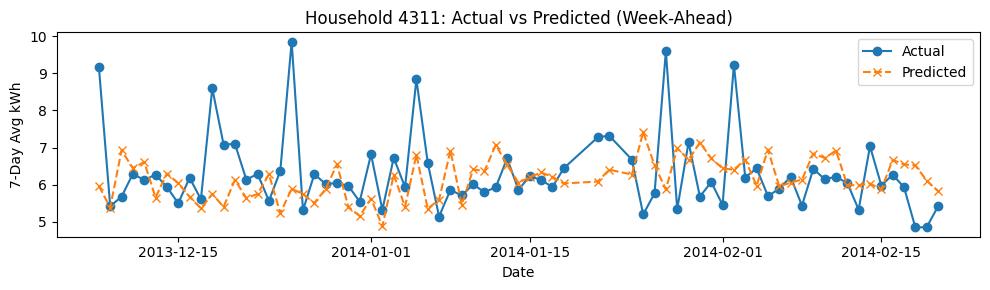

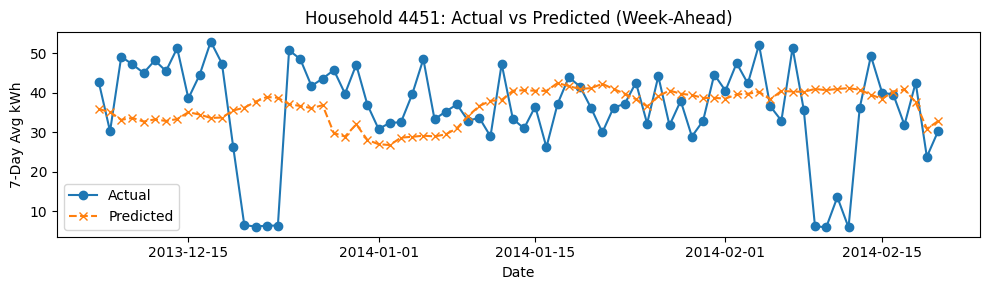

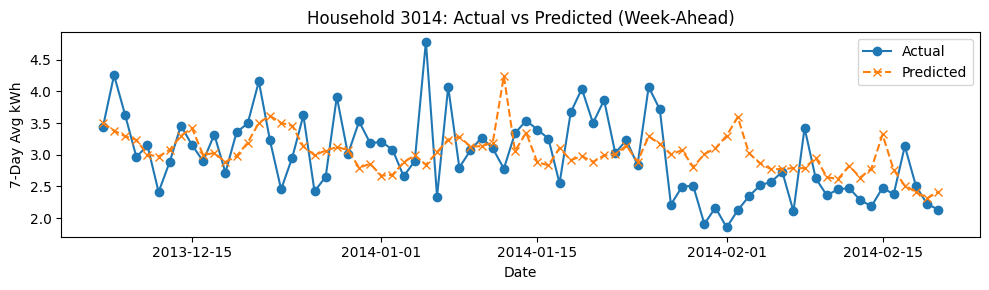

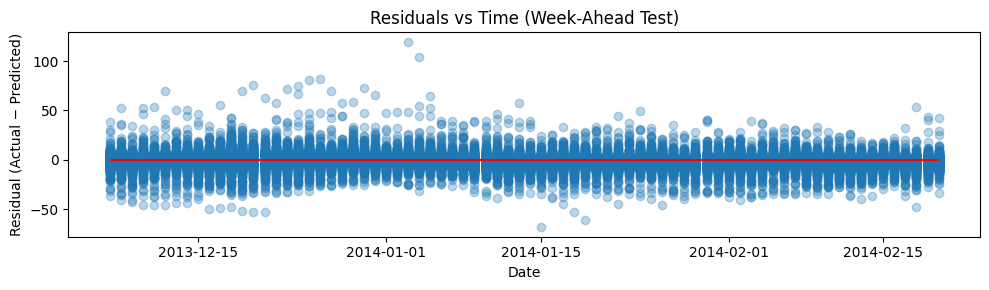

In [32]:
# ### Plot Actual vs Predicted (Week‐Ahead) for Sample Households

#%%
unique_hh_week = np.unique(hh_test)
sample_hhs_week = np.random.choice(unique_hh_week, size=3, replace=False)

for hh in sample_hhs_week:
    hh_mask = (hh_test == hh)
    dates = date_test[hh_mask]
    y_true_hh = y_test[hh_mask]
    y_pred_hh = y_test_pred[hh_mask]

    plt.figure(figsize=(10, 3))
    plt.plot(dates, y_true_hh, label="Actual", marker='o', linestyle='-')
    plt.plot(dates, y_pred_hh, label="Predicted", marker='x', linestyle='--')
    plt.title(f"Household {hh}: Actual vs Predicted (Week‐Ahead)")
    plt.xlabel("Date")
    plt.ylabel("7‐Day Avg kWh")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ### Plot Residuals vs Time (Week‐Ahead)

#%%
residuals_week = y_test- y_test_pred
plt.figure(figsize=(10, 3))
plt.scatter(date_test, residuals_week, alpha=0.3)
plt.hlines(0, xmin=date_test.min(), xmax=date_test.max(), colors="red")
plt.title("Residuals vs Time (Week‐Ahead Test)")
plt.xlabel("Date")
plt.ylabel("Residual (Actual − Predicted)")
plt.tight_layout()
plt.show()

In [33]:

# Create evaluation DataFrame with corrected predictions
df_eval_week = pd.DataFrame({
    "cluster": cl_test,
    "y_true": y_test,
    "y_pred": y_test_pred_corrected
})
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100 if mask.any() else np.nan
cluster_scores_week = []
for cluster_id in sorted(df_eval_week["cluster"].unique()):
    df_c = df_eval_week[df_eval_week["cluster"] == cluster_id]
    y_true = df_c["y_true"]
    y_pred = df_c["y_pred"]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

    cluster_scores_week.append({
        "Cluster": cluster_id,
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4),
        "R2": round(r2, 4),
        "SMAPE (%)": round(smape, 2),
        "Samples": len(df_c),
        "Model": "LSTM (Week-Ahead)"
    })

cluster_eval_week_df = pd.DataFrame(cluster_scores_week)
cluster_eval_week_df

,Cluster,MAE,RMSE,R2,SMAPE (%),Samples,Model
0,0,3.8000,6.3717,0.7087,24.47,36528,LSTM (Week-Ahead)
1,1,1.8749,3.9232,0.2548,55.00,12116,LSTM (Week-Ahead)
2,2,1.4949,2.6510,0.3217,28.73,15038,LSTM (Week-Ahead)
3,3,2.5449,4.1358,0.5595,23.94,33582,LSTM (Week-Ahead)


In [34]:
# Filter only Cluster 2 households
cluster_2_df = df_features[df_features["autoencoder_cluster"] == 2]
print(f"Cluster 2 sample size: {len(cluster_2_df):,}")


Cluster 2 sample size: 169,147


In [35]:
train_df, val_df, test_df, feature_cols, _, _ = prepare_weekahead_data(
    cluster_2_df, cluster_2_df,
    test_days=CONFIG["test_days"],
    val_days=CONFIG["val_days"]
)

✅ Week‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 132,461  (Households: 1163)
   ✅ Val rows:   13,225  (Households: 681)
   ✅ Test rows:  14,725  (Households: 533)
   ✅ Train period: 2011-11-27 to 2013-09-23
   ✅ Val period:   2013-09-24 to 2013-11-22
   ✅ Test period:  2013-11-23 to 2014-02-20
   ✅ Initial features (before static): 61
   ✅ Final features (including static): 64
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_7'


In [36]:
(
    X_train, y_train, hh_train, cl_train, date_train,
    X_val, y_val, hh_val, cl_val, date_val,
    X_test, y_test, hh_test, cl_test, date_test
) = build_global_sequences_with_dates(
    train_df, val_df, test_df,
    feature_cols=feature_cols,
    target_col=CONFIG["target_col"],
    seq_len=CONFIG["seq_length"],
    group_col=CONFIG["group_col"],
    household_col=CONFIG["household_col"],
    cluster_col=CONFIG["cluster_col"],
    date_col=CONFIG["date_col"]
)

In [37]:
# ---------------- BUILD MODEL ----------------
model = LSTMForecaster(
    seq_length=CONFIG["seq_length"],
    n_features=len(feature_cols),
    hidden_units=CONFIG["hidden_units"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    use_embedding=True,
    embedding_dim=CONFIG["embedding_dim"],
    use_cluster_embedding=True,
    cluster_embedding_dim=CONFIG["cluster_embedding_dim"],
    n_clusters=df_features[CONFIG["cluster_col"]].nunique(),
    scale_features=CONFIG["scale_features"],
    scale_target=CONFIG["scale_target"],
    use_attention=CONFIG["use_attention"],
    random_state=CONFIG["seed"]
)

model.build_model(
    n_features=len(feature_cols),
    n_households=df_features[CONFIG["household_col"]].nunique(),
    n_clusters=df_features[CONFIG["cluster_col"]].nunique()
)

# ---------------- TRAIN ----------------
model.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    household_train=hh_train, household_val=hh_val,
    cluster_train=cl_train, cluster_val=cl_val,
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    early_stopping=True,
    patience=CONFIG["early_stopping_patience"],
    verbose=2
)

Epoch 1/50
1735/1735 - 19s - 11ms/step - coeff_determination: -8.4050e+01 - loss: 0.6971 - mae: 0.6483 - val_coeff_determination: -8.7314e+01 - val_loss: 0.5295 - val_mae: 0.5682 - learning_rate: 0.0010
Epoch 2/50
1735/1735 - 13s - 8ms/step - coeff_determination: -8.6269e+01 - loss: 0.6591 - mae: 0.6282 - val_coeff_determination: -8.7927e+01 - val_loss: 0.5183 - val_mae: 0.5590 - learning_rate: 0.0010
Epoch 3/50
1735/1735 - 13s - 8ms/step - coeff_determination: -8.7649e+01 - loss: 0.6363 - mae: 0.6166 - val_coeff_determination: -9.0261e+01 - val_loss: 0.5213 - val_mae: 0.5605 - learning_rate: 0.0010
Epoch 4/50
1735/1735 - 13s - 8ms/step - coeff_determination: -8.8929e+01 - loss: 0.6154 - mae: 0.6059 - val_coeff_determination: -9.0478e+01 - val_loss: 0.5237 - val_mae: 0.5627 - learning_rate: 0.0010
Epoch 5/50
1735/1735 - 13s - 8ms/step - coeff_determination: -9.0275e+01 - loss: 0.5939 - mae: 0.5948 - val_coeff_determination: -8.9410e+01 - val_loss: 0.5144 - val_mae: 0.5550 - learning_ra

In [38]:
# Predict on test set
y_test_pred = model.predict(X_test, hh_test, cl_test)
bias = np.mean(y_test_pred - y_test)
y_test_pred_corrected = y_test_pred - bias
print(f"✅ Applied test bias correction: {bias:.4f} kWh")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100 if mask.any() else np.nan

# Build DataFrame
df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_test_pred_corrected
})

# Compute metrics
mae = mean_absolute_error(df_eval["y_true"], df_eval["y_pred"])
rmse = mean_squared_error(df_eval["y_true"], df_eval["y_pred"], squared=False)
r2 = r2_score(df_eval["y_true"], df_eval["y_pred"])
smape = symmetric_mean_absolute_percentage_error(df_eval["y_true"], df_eval["y_pred"])

# Assemble results
cluster2_eval_df = pd.DataFrame([{
    "Cluster": 2,
    "MAE": round(mae, 4),
    "RMSE": round(rmse, 4),
    "R2": round(r2, 4),
    "SMAPE (%)": round(smape, 2),
    "Samples": len(df_eval),
    "Model": "LSTM (Cluster 2, Week-Ahead)"
}])
cluster2_eval_df

✅ Applied test bias correction: 0.0756 kWh


,Cluster,MAE,RMSE,R2,SMAPE (%),Samples,Model
0,2,0.4482,0.5789,0.3394,10.36,8739,"LSTM (Cluster 2, Week-Ahead)"


In [39]:
# Filter only Cluster 1 households
cluster_1_df = df_features[df_features["autoencoder_cluster"] == 1]
print(f"Cluster 1 sample size: {len(cluster_1_df):,}")


Cluster 1 sample size: 132,672


In [40]:
train_df, val_df, test_df, feature_cols, _, _ = prepare_weekahead_data(
    cluster_1_df, cluster_1_df,
    test_days=CONFIG["test_days"],
    val_days=CONFIG["val_days"]
)

✅ Week‐ahead data prepared in a leakage‐safe manner
   ✅ Train rows: 103,098  (Households: 887)
   ✅ Val rows:   10,475  (Households: 452)
   ✅ Test rows:  12,070  (Households: 380)
   ✅ Train period: 2011-11-24 to 2013-09-23
   ✅ Val period:   2013-09-24 to 2013-11-22
   ✅ Test period:  2013-11-23 to 2014-02-20
   ✅ Initial features (before static): 61
   ✅ Final features (including static): 64
   ✅ Feature groups: 8 groups
   ✅ Target:       'label_7'


In [41]:
(
    X_train, y_train, hh_train, cl_train, date_train,
    X_val, y_val, hh_val, cl_val, date_val,
    X_test, y_test, hh_test, cl_test, date_test
) = build_global_sequences_with_dates(
    train_df, val_df, test_df,
    feature_cols=feature_cols,
    target_col=CONFIG["target_col"],
    seq_len=CONFIG["seq_length"],
    group_col=CONFIG["group_col"],
    household_col=CONFIG["household_col"],
    cluster_col=CONFIG["cluster_col"],
    date_col=CONFIG["date_col"]
)

In [42]:
# ---------------- BUILD MODEL ----------------
model = LSTMForecaster(
    seq_length=CONFIG["seq_length"],
    n_features=len(feature_cols),
    hidden_units=CONFIG["hidden_units"],
    dropout=CONFIG["dropout"],
    learning_rate=CONFIG["learning_rate"],
    use_embedding=True,
    embedding_dim=CONFIG["embedding_dim"],
    use_cluster_embedding=True,
    cluster_embedding_dim=CONFIG["cluster_embedding_dim"],
    n_clusters=df_features[CONFIG["cluster_col"]].nunique(),
    scale_features=CONFIG["scale_features"],
    scale_target=CONFIG["scale_target"],
    use_attention=CONFIG["use_attention"],
    random_state=CONFIG["seed"]
)

model.build_model(
    n_features=len(feature_cols),
    n_households=df_features[CONFIG["household_col"]].nunique(),
    n_clusters=df_features[CONFIG["cluster_col"]].nunique()
)

# ---------------- TRAIN ----------------
model.fit(
    X_train, y_train,
    X_val=X_val, y_val=y_val,
    household_train=hh_train, household_val=hh_val,
    cluster_train=cl_train, cluster_val=cl_val,
    epochs=CONFIG["epochs"],
    batch_size=CONFIG["batch_size"],
    early_stopping=True,
    patience=CONFIG["early_stopping_patience"],
    verbose=2
)

Epoch 1/50
1364/1364 - 16s - 12ms/step - coeff_determination: -9.3508e+01 - loss: 0.5379 - mae: 0.5540 - val_coeff_determination: -9.5359e+01 - val_loss: 0.5036 - val_mae: 0.5121 - learning_rate: 0.0010
Epoch 2/50
1364/1364 - 10s - 8ms/step - coeff_determination: -9.7588e+01 - loss: 0.4724 - mae: 0.5150 - val_coeff_determination: -9.9504e+01 - val_loss: 0.5173 - val_mae: 0.5170 - learning_rate: 0.0010
Epoch 3/50
1364/1364 - 11s - 8ms/step - coeff_determination: -1.0010e+02 - loss: 0.4318 - mae: 0.4919 - val_coeff_determination: -1.0398e+02 - val_loss: 0.5506 - val_mae: 0.5363 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1364/1364 - 11s - 8ms/step - coeff_determination: -1.0235e+02 - loss: 0.3960 - mae: 0.4698 - val_coeff_determination: -1.0248e+02 - val_loss: 0.5465 - val_mae: 0.5363 - learning_rate: 0.0010
Epoch 5/50
1364/1364 - 11s - 8ms/step - coeff_determination: -1.0503e+02 - loss: 0.3516 - mae: 0.4409 - val_coeff_

In [43]:
# Predict on test set
y_test_pred = model.predict(X_test, hh_test, cl_test)
bias = np.mean(y_test_pred - y_test)
y_test_pred_corrected = y_test_pred - bias
print(f"✅ Applied test bias correction: {bias:.4f} kWh")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denom != 0
    return np.mean(np.abs(y_true[mask] - y_pred[mask]) / denom[mask]) * 100 if mask.any() else np.nan

# Build DataFrame
df_eval = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_test_pred_corrected
})

# Compute metrics
mae = mean_absolute_error(df_eval["y_true"], df_eval["y_pred"])
rmse = mean_squared_error(df_eval["y_true"], df_eval["y_pred"], squared=False)
r2 = r2_score(df_eval["y_true"], df_eval["y_pred"])
smape = symmetric_mean_absolute_percentage_error(df_eval["y_true"], df_eval["y_pred"])

# Assemble results
cluster1_eval_df = pd.DataFrame([{
    "Cluster": 1,
    "MAE": round(mae, 4),
    "RMSE": round(rmse, 4),
    "R2": round(r2, 4),
    "SMAPE (%)": round(smape, 2),
    "Samples": len(df_eval),
    "Model": "LSTM (Cluster 1, Week-Ahead)"
}])
cluster1_eval_df

✅ Applied test bias correction: 0.0103 kWh


,Cluster,MAE,RMSE,R2,SMAPE (%),Samples,Model
0,1,0.4765,0.6367,0.5561,35.67,8067,"LSTM (Cluster 1, Week-Ahead)"


In [7]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

class TemporalAttention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.score_layer = layers.Dense(1)  

    def call(self, inputs):
        score = self.score_layer(inputs)   # [batch, time, 1]
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context


class LSTMForecaster:
    def __init__(
        self,
        seq_length=14,
        n_features=None,
        hidden_units=[128, 64],
        dropout=0.2,
        learning_rate=0.001,
        use_embedding=False,
        embedding_dim=8,
        use_cluster_embedding=False,
        cluster_embedding_dim=4,
        n_clusters=None,
        use_attention=True,
        scale_features=True,
        scale_target=True,
        random_state=42
    ):
        self.seq_length = seq_length
        self.n_features = n_features
        self.hidden_units = hidden_units
        self.dropout = dropout
        self.learning_rate = learning_rate
        self.use_embedding = use_embedding
        self.embedding_dim = embedding_dim
        self.use_cluster_embedding = use_cluster_embedding
        self.cluster_embedding_dim = cluster_embedding_dim
        self.n_clusters = n_clusters
        self.use_attention = use_attention
        self.scale_features = scale_features
        self.scale_target = scale_target
        self.random_state = random_state

        np.random.seed(random_state)
        tf.random.set_seed(random_state)

        self.model = None
        self.feature_scaler = StandardScaler() if self.scale_features else None
        self.target_scaler = StandardScaler() if self.scale_target else None

    def build_model(self, n_features=None, n_households=None, n_clusters=None):
        if n_features is not None:
            self.n_features = n_features
        if n_households is not None:
            self.n_households = n_households
        if n_clusters is not None:
            self.n_clusters = n_clusters

        sequence_input = layers.Input(shape=(self.seq_length, self.n_features), name="sequence_input")
        x = sequence_input
        inputs = [sequence_input]

        if self.use_embedding and self.n_households is not None:
            hh_input = layers.Input(shape=(1,), name="household_input")
            hh_embed = layers.Embedding(self.n_households, self.embedding_dim)(hh_input)
            hh_embed = layers.Flatten()(hh_embed)
            hh_embed = layers.RepeatVector(self.seq_length)(hh_embed)
            x = layers.Concatenate()([x, hh_embed])
            inputs.append(hh_input)

        if self.use_cluster_embedding and self.n_clusters is not None:
            cl_input = layers.Input(shape=(1,), name="cluster_input")
            cl_embed = layers.Embedding(self.n_clusters, self.cluster_embedding_dim)(cl_input)
            cl_embed = layers.Flatten()(cl_embed)
            cl_embed = layers.RepeatVector(self.seq_length)(cl_embed)
            x = layers.Concatenate()([x, cl_embed])
            inputs.append(cl_input)

        for i, units in enumerate(self.hidden_units):
            return_sequences = self.use_attention or (i < len(self.hidden_units) - 1)
            x = layers.LSTM(units, return_sequences=return_sequences)(x)
            if self.dropout > 0:
                x = layers.Dropout(self.dropout)(x)

        if self.use_attention:
            x = TemporalAttention()(x)

        # Add learnable bias per cluster
        if self.use_cluster_embedding and self.n_clusters is not None:
            bias = layers.Embedding(self.n_clusters, 1, name="cluster_bias")(cl_input)
            bias = layers.Flatten()(bias)
            x = layers.Dense(1)(x)
            output = layers.Add(name="bias_corrected_output")([x, bias])
        else:
            output = layers.Dense(1)(x)

        self.model = keras.Model(inputs=inputs, outputs=output)

        def coeff_determination(y_true, y_pred):
            SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
            SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
            return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            loss="mse",
            metrics=["mae", coeff_determination]
        )
        return self.model

    def _prepare_data(self, X, y=None, fit_scalers=False):
        X_scaled = X.copy()
        if self.scale_features and self.feature_scaler:
            X_reshaped = X.reshape(-1, X.shape[-1])
            if fit_scalers:
                X_scaled = self.feature_scaler.fit_transform(X_reshaped).reshape(X.shape)
            else:
                X_scaled = self.feature_scaler.transform(X_reshaped).reshape(X.shape)

        if y is not None:
            y_scaled = y.copy()
            if self.scale_target and self.target_scaler:
                if fit_scalers:
                    y_scaled = self.target_scaler.fit_transform(y.reshape(-1, 1)).ravel()
                else:
                    y_scaled = self.target_scaler.transform(y.reshape(-1, 1)).ravel()
            return X_scaled, y_scaled
        return X_scaled

    def fit(self, X_train, y_train, X_val=None, y_val=None,
            household_train=None, household_val=None,
            cluster_train=None, cluster_val=None,
            epochs=50, batch_size=64, early_stopping=True, patience=10, verbose=1):

        if self.model is None:
            self.build_model(
                n_features=X_train.shape[-1],
                n_households=len(np.unique(household_train)) if household_train is not None else None,
                n_clusters=len(np.unique(cluster_train)) if cluster_train is not None else None
            )

        X_train_scaled, y_train_scaled = self._prepare_data(X_train, y_train, fit_scalers=True)
        train_inputs = [X_train_scaled]
        if self.use_embedding:
            train_inputs.append(household_train)
        if self.use_cluster_embedding:
            train_inputs.append(cluster_train)

        validation_data = None
        if X_val is not None and y_val is not None:
            X_val_scaled, y_val_scaled = self._prepare_data(X_val, y_val, fit_scalers=False)
            val_inputs = [X_val_scaled]
            if self.use_embedding:
                val_inputs.append(household_val)
            if self.use_cluster_embedding:
                val_inputs.append(cluster_val)
            validation_data = (val_inputs, y_val_scaled)

        callbacks_list = []
        if early_stopping and validation_data:
            callbacks_list.append(keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=patience, restore_best_weights=True, verbose=verbose))
            callbacks_list.append(keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=patience//2, verbose=verbose))

        self.history = self.model.fit(
            train_inputs, y_train_scaled,
            epochs=epochs, batch_size=batch_size,
            validation_data=validation_data,
            callbacks=callbacks_list, verbose=verbose
        )
        return self

    def predict(self, X, household_codes=None, cluster_codes=None):
        X_scaled = self._prepare_data(X, fit_scalers=False)
        inputs = [X_scaled]
        if self.use_embedding:
            inputs.append(household_codes)
        if self.use_cluster_embedding:
            inputs.append(cluster_codes)
        y_pred_scaled = self.model.predict(inputs, verbose=0).ravel()
        if self.scale_target and self.target_scaler:
            return self.target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        return y_pred_scaled

    def evaluate(self, X, y, household_codes=None, cluster_codes=None):
        y_pred = self.predict(X, household_codes, cluster_codes)
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        bias = np.mean(y_pred - y)
        mape = np.mean(np.abs((y - y_pred) / np.clip(y, 1e-6, None))) * 100
        return {"mae": mae, "rmse": rmse, "r2": r2, "bias": bias, "mape": mape}

    def get_model_summary(self):
        return self.model.summary() if self.model else "Model not built yet."


In [6]:
"""
src/utils/sequence_builder.py

Utility functions to convert a feature-engineered DataFrame into sliding-window
(“sequence”) inputs for LSTM training. Supports both global (all households)
and per-household sequence construction. Handles optional household_code alignment,
and can optionally return the target dates for plotting.

Author: Shruthi Simha Chippagiri
Date: 2025
"""

import numpy as np
import pandas as pd


def build_sequences(
    df: pd.DataFrame,
    feature_cols: list,
    target_col: str,
    seq_len: int,
    group_col: str = "LCLid",
    include_household: bool = False,
    household_col: str = "household_code"
):
    X_list = []
    y_list = []
    hh_list = []

    for hh, group_df in df.groupby(group_col):
        group_df = group_df.reset_index(drop=True)

        if include_household:
            hh_series = group_df[household_col].values

        features_array = group_df[feature_cols].values
        target_array = group_df[target_col].values

        for i in range(len(group_df) - seq_len):
            window_feats = features_array[i : i + seq_len]
            window_target = target_array[i + seq_len]

            if np.any(pd.isnull(window_feats)) or pd.isnull(window_target):
                continue

            X_list.append(window_feats)
            y_list.append(window_target)
            if include_household:
                hh_list.append(hh_series[i + seq_len])

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=float)

    if include_household:
        hh_codes = np.array(hh_list, dtype=int)
        return X, y, hh_codes

    return X, y


def build_global_sequences(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_cols: list,
    target_col: str,
    seq_len: int,
    group_col: str = "LCLid",
    household_col: str = "household_code"
):
    X_train, y_train, hh_train = build_sequences(
        train_df, feature_cols, target_col, seq_len,
        group_col=group_col,
        include_household=True,
        household_col=household_col
    )
    X_val, y_val, hh_val = build_sequences(
        val_df, feature_cols, target_col, seq_len,
        group_col=group_col,
        include_household=True,
        household_col=household_col
    )
    X_test, y_test, hh_test = build_sequences(
        test_df, feature_cols, target_col, seq_len,
        group_col=group_col,
        include_household=True,
        household_col=household_col
    )

    return (X_train, y_train, hh_train,
            X_val,   y_val,   hh_val,
            X_test,  y_test,  hh_test)


def build_sequences_with_dates(
    df: pd.DataFrame,
    feature_cols: list,
    target_col: str,
    seq_len: int,
    group_col: str = "LCLid",
    include_household: bool = False,
    household_col: str = "household_code",
    include_cluster: bool = False,
    cluster_col: str = "cluster_code",
    date_col: str = "day"
):
    X_list = []
    y_list = []
    hh_list = []
    cl_list = []
    date_list = []

    for hh, group_df in df.groupby(group_col):
        group_df = group_df.reset_index(drop=True)

        if include_household:
            hh_series = group_df[household_col].values
        if include_cluster:
            cl_series = group_df[cluster_col].values

        features_array = group_df[feature_cols].values
        target_array = group_df[target_col].values
        date_array = pd.to_datetime(group_df[date_col]).values

        for i in range(len(group_df) - seq_len):
            window_feats = features_array[i : i + seq_len]
            window_target = target_array[i + seq_len]
            window_date = date_array[i + seq_len]

            if np.any(pd.isnull(window_feats)) or pd.isnull(window_target):
                continue

            X_list.append(window_feats)
            y_list.append(window_target)
            date_list.append(window_date)

            if include_household:
                hh_list.append(hh_series[i + seq_len])
            if include_cluster:
                cl_list.append(cl_series[i + seq_len])

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=float)
    dates = np.array(date_list, dtype="datetime64[ns]")

    output = [X, y]
    if include_household:
        output.append(np.array(hh_list, dtype=int))
    if include_cluster:
        output.append(np.array(cl_list, dtype=int))
    output.append(dates)

    return tuple(output)


def build_global_sequences_with_dates(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    feature_cols: list,
    target_col: str,
    seq_len: int,
    group_col: str = "LCLid",
    household_col: str = "household_code",
    cluster_col: str = "autoencoder_cluster",  # <- patched here
    date_col: str = "day"
):
    train_out = build_sequences_with_dates(
        train_df, feature_cols, target_col, seq_len,
        group_col=group_col,
        include_household=True,
        household_col=household_col,
        include_cluster=True,
        cluster_col=cluster_col,
        date_col=date_col
    )
    val_out = build_sequences_with_dates(
        val_df, feature_cols, target_col, seq_len,
        group_col=group_col,
        include_household=True,
        household_col=household_col,
        include_cluster=True,
        cluster_col=cluster_col,
        date_col=date_col
    )
    test_out = build_sequences_with_dates(
        test_df, feature_cols, target_col, seq_len,
        group_col=group_col,
        include_household=True,
        household_col=household_col,
        include_cluster=True,
        cluster_col=cluster_col,
        date_col=date_col
    )

    return (
        train_out[0], train_out[1], train_out[2], train_out[3], train_out[4],
        val_out[0],   val_out[1],   val_out[2],   val_out[3],   val_out[4],
        test_out[0],  test_out[1],  test_out[2],  test_out[3],  test_out[4]
    )
